In [49]:
# standard libraries

import datetime
import math
import pathlib
import sqlite3
import sys

# installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy
import ipywidgets

# append to root directory this repo
sys.path.append("../")

# auxiliary module
from auxiliary import photometry

In [50]:
# Access the NEO database

database_dir = pathlib.Path("../databases/neos/")
database_file = pathlib.Path("neodys.db")
database_filepath = database_dir / database_file

# establish a connection to the database with a cursor
neodys_db_con = sqlite3.connect(database_filepath)
neodys_db_cur = neodys_db_con.cursor()


In [51]:
# dataframe

neo_df = pd.read_sql("SELECT * FROM main", neodys_db_con)
neodys_db_con.close()

In [52]:
neo_df

,Name,Epoch_MJD,SemMajAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,AbsMag_,SlopeParamG_,Aphel_AU,Perihel_AU,NEOClass
0,433,60000.0,1.458129,0.222782,10.827822,304.287024,178.926986,110.777664,10.91,0.46,1.782974,1.133284,Amor
1,719,60600.0,2.636157,0.546780,11.575260,183.857164,156.215517,148.450677,15.54,0.15,4.077554,1.194760,Amor
2,887,60600.0,2.472525,0.571093,9.398798,110.423047,350.474210,340.198429,13.40,-0.12,3.884567,1.060483,Amor
3,1036,60600.0,2.665299,0.532826,26.686737,215.494963,132.496161,6.984965,9.46,0.30,4.085439,1.245159,Amor
4,1221,60600.0,1.920154,0.434718,11.868483,171.260808,26.717609,271.700797,17.42,0.15,2.754880,1.085428,Amor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35925,2024SY6,60600.0,1.995505,0.659345,6.776679,192.144115,93.914677,22.702933,24.97,0.15,3.311232,0.679779,Apollo
35926,2024SZ3,60600.0,2.107524,0.439275,4.559708,38.817842,306.522612,11.474119,23.57,0.15,3.033307,1.181741,Amor
35927,2024SZ4,60600.0,3.001764,0.606008,18.515143,225.689635,163.476550,1.188634,21.02,0.15,4.820857,1.182672,Amor
35928,2024SZ5,60600.0,2.485290,0.577793,1.574992,323.150490,41.001150,5.152813,25.43,0.15,3.921273,1.049306,Amor


In [53]:
# kernels

# lsk - leapseconds kernel
spiceypy.furnsh("/home/astavak/python/kernels/lsk/naif0012.tls")

# barycenter bsp 1549 DEC 31 --- 2650 JAN 25
spiceypy.furnsh("/home/astavak/python/kernels/spk/de440s.bsp")

# pck - "GM" (gravitational constant times mass)
spiceypy.furnsh("/home/astavak/python/kernels/pck/gm_de440.tpc")

# constant gravitational parameter of Sun (bodvcd: body-vector-constant)
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item="GM", maxn=1)
print(gm_sun_pre)

gm_sun = gm_sun_pre[0]

[1.3271244e+11]


In [54]:
help(spiceypy.bodvcd)

Help on function bodvcd in module spiceypy.spiceypy:

bodvcd(bodyid: int, item: str, maxn: int) -> Tuple[int, numpy.ndarray]
    Fetch from the kernel pool the double precision values of an item
    associated with a body, where the body is specified by an integer ID
    code.

    https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/bodvcd_c.html

    :param bodyid: Body ID code.
    :param item:
                Item for which values are desired,
                ("RADII", "NUT_PREC_ANGLES", etc.)
    :param maxn: Maximum number of values that may be returned.
    :return: dim, values



In [55]:
# determine today's datetime at midnight Julian Date

curr_time_et = spiceypy.utc2et(datetime.datetime.now().strftime("%Y-%m-%d"))
print(curr_time_et)

781444869.1823432


In [56]:
# position vector
sun2earth_position_vec = spiceypy.spkgps(targ=399,
                                        et=curr_time_et,
                                        ref="ECLIPJ2000",
                                        obs=10)[0]

sun2earth_position_vec

array([ 1.45795833e+08,  3.33721487e+07, -2.40579837e+03])

In [57]:
# AU -> kms and deg -> rad. Later used for apparent magnitude and position vector

neo_df.loc[:, "Perihel_km"] = neo_df["Perihel_AU"].apply(lambda x: abs(spiceypy.convrt(x, "AU", "km")))
neo_df.loc[:, "Incl_rad"] = neo_df["Incl_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "LongAscNode_rad"] = neo_df["LongAscNode_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "ArgP_rad"] = neo_df["ArgP_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "MeanAnom_rad"] = neo_df["MeanAnom_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "Epoch_JD"] = neo_df["Epoch_MJD"].apply(lambda x: x + 2400000.5)
neo_df.loc[:, "Epoch_et"] = neo_df["Epoch_JD"].apply(lambda x: spiceypy.utc2et(str(x) + "JD"))

In [58]:
help(spiceypy.conics)

Help on function conics in module spiceypy.spiceypy:

conics(elts: numpy.ndarray, et: float) -> numpy.ndarray
    Determine the state (position, velocity) of an orbiting body
    from a set of elliptic, hyperbolic, or parabolic orbital
    elements.

    https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/conics_c.html

    :param elts: Conic elements.
    :param et: Input time.
    :return: State of orbiting body at et.



In [59]:
neo_df.loc[:, "sun2neo_position_vec"] = \
    neo_df.apply(lambda x: spiceypy.conics(elts=[x["Perihel_km"],
                                                    x["Ecc_"],
                                                    x["Incl_rad"],
                                                    x["LongAscNode_rad"],
                                                    x["ArgP_rad"],
                                                    x["MeanAnom_rad"],
                                                    x["Epoch_et"],
                                                    gm_sun],
                                                    et=curr_time_et)[:3],
                                                    axis=1)
print(neo_df["sun2neo_position_vec"][0])

[-1.41143816e+08 -1.65087545e+08 -4.00920668e+07]


We can verify the value from https://ssd.jpl.nasa.gov/horizons/app.html#/ 

:type: vector table

:cordinate center: Solar System Barycenter (SSB)


In [60]:
# Computing app mag to re-compute the positional vector and convert back to AU
neo_df.loc[:, "neo2earth_position_vec"] = \
    neo_df["sun2neo_position_vec"].apply(lambda x: sun2earth_position_vec - x)

print(neo_df["neo2earth_position_vec"][0])

neo_df.loc[:, "neo2sun_position_vec"] = \
    neo_df["sun2neo_position_vec"].apply(lambda x: -1.0 * x)


# spicecypy supports vectorised operation -- (if not the for loop solution)
neo_df.loc[:, "neo2earth_position_vec_AU"] = \
    neo_df["neo2earth_position_vec"].apply(lambda x: spiceypy.convrt(x, "km", "AU"))

print(neo_df["neo2earth_position_vec_AU"][0])

neo_df.loc[:, "neo2sun_position_vec_AU"] = \
    neo_df["neo2sun_position_vec"].apply(lambda x: spiceypy.convrt(x, "km", "AU"))

print(neo_df["neo2sun_position_vec_AU"][0])

[2.86939649e+08 1.98459693e+08 4.00896610e+07]
[1.91807308 1.32662111 0.26798283]
[0.94348813 1.10354208 0.26799891]


In [61]:
neo_df.loc[:, "app_mag"] = neo_df.apply(lambda x: photometry.hg_app_mag(abs_mag=x["AbsMag_"],
                                                                        vec_obj2obs=x["neo2earth_position_vec_AU"],
                                                                        vec_obj2ill=x["neo2sun_position_vec_AU"],
                                                                        slope_g=x["SlopeParamG_"]), axis=1)

In [62]:
neo_df[["Name", "AbsMag_", "app_mag"]].sort_values(by="app_mag")

,Name,AbsMag_,app_mag
7582,2010LB67,0.17,1.938593
7589,2010LF64,0.17,2.107481
3,1036,9.46,9.185535
80,4954,12.59,11.212221
313,66146,14.45,13.336279
...,...,...,...
31374,2023CL2,24.89,42.016763
35533,2024RC42,32.38,42.177978
22669,2020HE7,28.80,42.937761
1625,392704,18.97,44.470829


In [63]:
neos_2_del = ["2010LB67", "2010LF64"]
neo_df = neo_df[~neo_df["Name"].isin(neos_2_del)].copy()

neo_df.reset_index(drop=True, inplace=True)

neo_df

,Name,Epoch_MJD,SemMajAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,AbsMag_,SlopeParamG_,...,ArgP_rad,MeanAnom_rad,Epoch_JD,Epoch_et,sun2neo_position_vec,neo2earth_position_vec,neo2sun_position_vec,neo2earth_position_vec_AU,neo2sun_position_vec_AU,app_mag
0,433,60000.0,1.458129,0.222782,10.827822,304.287024,178.926986,110.777664,10.91,0.46,...,3.122865,1.933435,2460000.5,7.305553e+08,"[-141143815.8395639, -165087544.6801074, -4009...","[286939648.557305, 198459693.41330427, 4008966...","[141143815.8395639, 165087544.6801074, 4009206...","[1.9180730807210349, 1.3266211116453173, 0.267...","[0.9434881342933275, 1.103542075852256, 0.2679...",14.155786
1,719,60600.0,2.636157,0.546780,11.575260,183.857164,156.215517,148.450677,15.54,0.15,...,2.726475,2.590953,2460600.5,7.823953e+08,"[-502860260.45960224, 308281300.45641375, -699...","[648656093.1773434, -274909151.7232169, 699254...","[502860260.45960224, -308281300.45641375, 6992...","[4.335998169735903, -1.8376541764630003, 0.467...","[3.3614132233081953, -2.0607332122560615, 0.46...",22.497091
2,887,60600.0,2.472525,0.571093,9.398798,110.423047,350.474210,340.198429,13.40,-0.12,...,6.116929,5.937583,2460600.5,7.823953e+08,"[203973312.62685516, 84304451.02497792, -36510...","[-58177479.90911409, -50932302.29178107, 36507...","[-203973312.62685516, -84304451.02497792, 3651...","[-0.3888924332308684, -0.340461412203554, 0.24...","[-1.3634773796585757, -0.5635404479966153, 0.2...",14.654711
3,1036,60600.0,2.665299,0.532826,26.686737,215.494963,132.496161,6.984965,9.46,0.30,...,2.312494,0.121911,2460600.5,7.823953e+08,"[182541459.75903827, 25522178.211704325, 42831...","[-36745627.0412972, 7849970.52149253, -4283385...","[-182541459.75903827, -25522178.211704325, -42...","[-0.2456293454616513, 0.052473811888430866, -0...","[-1.2202142918893586, -0.17060522390463045, -0...",9.185535
4,1221,60600.0,1.920154,0.434718,11.868483,171.260808,26.717609,271.700797,17.42,0.15,...,0.466310,4.742073,2460600.5,7.823953e+08,"[160623937.45444328, 292271473.1746136, -65839...","[-14828104.736702204, -258899324.44141674, 658...","[-160623937.45444328, -292271473.1746136, 6583...","[-0.09911975802779485, -1.730635091123592, 0.4...","[-1.0737047044555021, -1.9537141269166531, 0.4...",21.620316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35923,2024SY6,60600.0,1.995505,0.659345,6.776679,192.144115,93.914677,22.702933,24.97,0.15,...,1.639120,0.396241,2460600.5,7.823953e+08,"[158159835.06984958, 34781136.45987736, -86804...","[-12364002.352108508, -1408987.7266805023, 843...","[-158159835.06984958, -34781136.45987736, 8680...","[-0.08264825095028557, -0.009418501218636823, ...","[-1.057233197377993, -0.23249753701169815, 0.0...",20.209023
35924,2024SZ3,60600.0,2.107524,0.439275,4.559708,38.817842,306.522612,11.474119,23.57,0.15,...,5.349829,0.200261,2460600.5,7.823953e+08,"[179123135.59711045, 24319114.61900021, -74434...","[-33327302.879369378, 9053034.114196643, 74410...","[-179123135.59711045, -24319114.61900021, 7443...","[-0.22277925977590607, 0.06051579529213066, 0....","[-1.1973642062036134, -0.16256324050093066, 0....",21.994486
35925,2024SZ4,60600.0,3.001764,0.606008,18.515143,225.689635,163.476550,1.188634,21.02,0.15,...,2.853204,0.020746,2460600.5,7.823953e+08,"[158726180.9422045, 75985787.25759913, 2026068...","[-12930348.224463433, -42613638.524402276, -20...","[-158726180.9422045, -75985787.25759913, -2026...","[-0.08643403927756341, -0.28485457947757004, -...","[-1.0610189857052708, -0.5079336152706314, -0....",20.788871
35926,2024SZ5,60600.0,2.485290,0.577793,1.574992,323.150490,41.001150,5.152813,25.43,0.15,...,0.715605,0.089934,2460600.5,7.823953e+08,"[152581769.03071105, 40930552.02526051, 341658...","[-6785936.312969983, -7558403.2920636535, -341...","[-152581769.03071105, -40930552.02526051, -341...","[-0.04536118251638428, -0.050524805340190625, ...","[-1.0199461289440916, -0.2736038411332519, -0....",21.316565


In [64]:
# from sqlalchemy import create_engine, BIGINT, Column, Float, Integer, MetaData, Table, Text

# database_dir =  pathlib.Path("../databases/neos/")
# database_file = "new_neo.db"
# database_filepath = database_dir / database_file
# engine = create_engine(f"sqlite:///{database_filepath}")

In [65]:
# metadata = MetaData()

# neo_table = Table(
#     'main', metadata,
#     Column('index', BIGINT),
#     Column('Name', String, primary_key=True),
#     Column('Epoch_MJD', Float),
#     Column('SemMajAxis_AU', Float),
#     Column('Ecc_', Float),
#     Column('Incl_deg', Float),
#     Column('LongAscNode_deg', Float),
#     Column('ArgP_deg', Float),
#     Column('MeanAnom_deg', Float),
#     Column('AbsMag_', Float),
#     Column('SlopeParamG_', Float),
#     Column('Aphel_AU', Float),
#     Column('Perihel_AU', Float),
#     Column('NEOClass', String),
#     Column('Perihel_km', Float),
#     Column('Incl_rad', Float),
#     Column('LongAscNode_rad', Float),
#     Column('ArgP_rad', Float),
#     Column('MeanAnom_rad', Float),
#     Column('Epoch_JD', Float),
#     Column('Epoch_et', Float),
#     Column('sun2neo_position_vec', Text),
#     Column('neo2earth_position_vec', Text),
#     Column('neo2sun_position_vec', Text),
#     Column('neo2earth_position_vec_AU', Text),
#     Column('neo2sun_position_vec_AU', Text),
#     Column('app_mag', Float)
# )

# metadata.create_all(engine)

In [66]:
# neo_df.to_sql('main', con=engine, if_exists='replace', index=False)

In [67]:
help(spiceypy.recrad)

Help on function recrad in module spiceypy.spiceypy:

recrad(rectan: Union[numpy.ndarray, Iterable[float]]) -> Tuple[float, float, float]
    Convert rectangular coordinates to range, right ascension, and declination.

    https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/recrad_c.html

    :param rectan: Rectangular coordinates of a point.
    :return:
            Distance of the point from the origin,
            Right ascension in radians,
            Declination in radians



In [68]:
# Now plot the Sun and its opposition on the ecliptic cordinate system. (measured on March equinox)

curr_time_utc = datetime.datetime.now().strftime("%Y-%m-%d")
# we multiply by "-1" for satisfying the triangle law of vector and measurement instead from sun use Earth
earth2sun_position_vec = -1.0 * sun2earth_position_vec

# rectangular cordinate system to RA and Dec
_, sun_ecl_long, sun_ecl_lat = spiceypy.recrad(earth2sun_position_vec)

# convert the values to determine "Opposition direction" 180 degree in direction and % 360 not to exceed the range
sun_opp_ecl_long = (sun_ecl_long + np.pi) % (2 * np.pi)
sun_opp_ecl_lat = -1.0 * sun_ecl_lat

# transform longitude values for matplotlib betwn -180 to 180 rad.
if sun_ecl_long > np.pi:
    sun_ecl_long_4plot = -1 * ((sun_ecl_long % np.pi) - np.pi)
else:
    sun_ecl_long_4plot = -1 * sun_ecl_long


if sun_opp_ecl_long > np.pi:
    sun_opp_ecl_long_4plot = -1 * ((sun_opp_ecl_long % np.pi) - np.pi)
else:
    sun_opp_ecl_long_4plot = -1 * sun_opp_ecl_long

In [69]:
# plotting for all the points

# We compute now the NEO's coordiantes in a similar way using the dataframe and the apply function.
neo_df.loc[:, "earth2neo_position_vec_AU"] = \
    neo_df["neo2earth_position_vec_AU"].apply(lambda x: -1.0 * np.array(x))

neo_df.loc[:, "earth2neo_recrad"] = \
    neo_df["earth2neo_position_vec_AU"].apply(lambda x: spiceypy.recrad(x))


# from earth2neo_recrad vals --> 3 output
neo_df.loc[:, "earth2neo_dist_AU"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[0])

neo_df.loc[:, "earth2neo_eclip_long"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[1])

neo_df.loc[:, "earth2neo_eclip_lat"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[2])


# conversion required for matplot lib -pi to pi and ivert as value plots from left to right
neo_df.loc[:, "earth2neo_eclip_long_4plot_ecl"] = \
    neo_df["earth2neo_eclip_long"].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

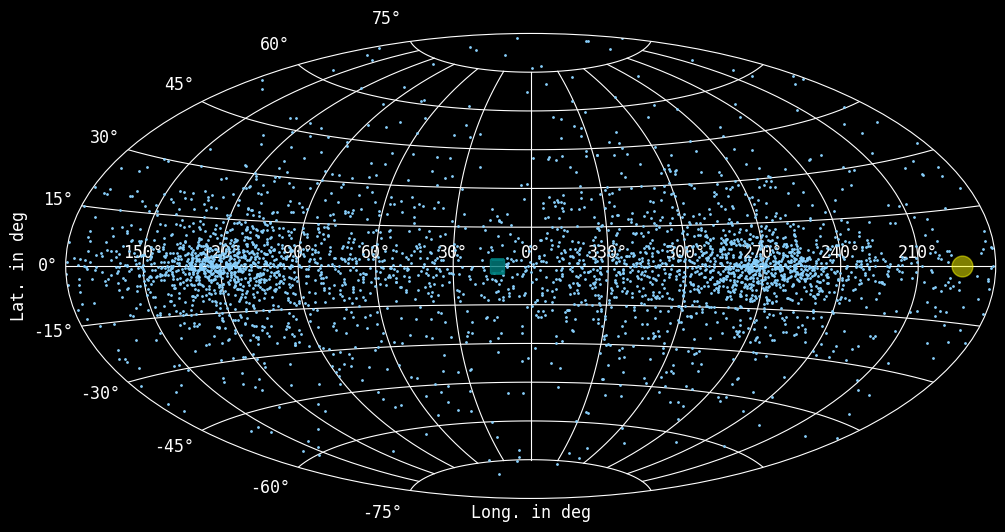

In [70]:
# ipywidgets to be added to play with the dial (app_mag, abs_mag, type, distance)
neo_sub_df = neo_df.loc[(neo_df["app_mag"] > 25) \
                        & (neo_df["AbsMag_"] > 20) \
                        & (neo_df["earth2neo_dist_AU"] < 1)].copy()

# print(neo_sub_df)

# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Set long. / lat. labels
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')

plt.plot(neo_sub_df["earth2neo_eclip_long_4plot_ecl"], \
         neo_sub_df["earth2neo_eclip_lat"], \
         marker='.', linestyle='None', markersize=2, alpha=1, color="lightskyblue")

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'])

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.5)

# Add the Opposition point
plt.plot(sun_opp_ecl_long_4plot,
         sun_opp_ecl_lat,
         color="teal",
         marker="s",
         markersize=10,
         alpha=0.8)

plt.show()

Figure above for based on panstars, sun in yellow and blue dot is the opposition.

In [71]:
neo_df.loc[:, "ang_dist_neo2sun_deg"] = \
    neo_df["earth2neo_position_vec_AU"].apply(lambda x:
                                              np.degrees(spiceypy.vsep(x, earth2sun_position_vec)))



In [72]:
#Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='Monospace', size=12)

# Set a function for the (interactive) plots
def plot_sky_map(neo_class, app_mag, abs_mag, ang_dist):

    # Set a figure
    plt.figure(figsize=(12, 8))

    # Apply the aitoff projection and activate the grid
    plt.subplot(projection="aitoff")
    plt.grid(True)

    # Set long. / lat. labels
    plt.xlabel('Long. in deg')
    plt.ylabel('Lat. in deg')

    # NEO Class filtering
    if neo_class == "All":
        _filtered_neo_df = neo_df.copy()
    else:
        _filtered_neo_df = neo_df.loc[neo_df["NEOClass"]==neo_class]

    # App. and Abs. Magnitude filtering
    _filtered_neo_df = _filtered_neo_df.loc[(_filtered_neo_df["app_mag"] >= app_mag[0])
                                            & (_filtered_neo_df["app_mag"] <= app_mag[1])]

    _filtered_neo_df = _filtered_neo_df.loc[(_filtered_neo_df["AbsMag_"] >= abs_mag[0])
                                            & (_filtered_neo_df["AbsMag_"] <= abs_mag[1])]

    # Angular distance filtering
    _filtered_neo_df = _filtered_neo_df.loc[_filtered_neo_df["ang_dist_neo2sun_deg"] > ang_dist]

    # Plotting the NEOs
    plt.plot(_filtered_neo_df["earth2neo_eclip_long_4plot_ecl"], \
             _filtered_neo_df["earth2neo_eclip_lat"], \
             marker='.',
             linestyle='None',
             markersize=2,
             alpha=1,
             color="lightskyblue")

    # Replace the standard x ticks (longitude) with the ecliptic coordinates
    plt.xticks(ticks=np.radians([-150,-120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
               labels=['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°',
                       '210°'])

    # Add the Sun
    plt.plot(sun_ecl_long_4plot,
             sun_ecl_lat,
             color="yellow",
             marker="o",
             markersize=15,
             alpha=0.5)

    # Add the Opposition point
    plt.plot(sun_opp_ecl_long_4plot,
             sun_opp_ecl_lat,
             color="teal",
             marker="s",
             markersize=10,
             alpha=0.8)

    # Plot the total number of visible NEOs
    plt.title(f"Total NEOs: {len(_filtered_neo_df)}", fontsize=12)

    # print(_filtered_neo_df)

    plt.show()


In [73]:
# We add also a drop-down menu to select the NEO class
neo_class_widget = ipywidgets.Dropdown(
    options=['Amor', 'Apollo', 'Aten', 'Atira', 'Other', 'All'],
    description="NEO Class"
)

# 2 selection range slider to add filtering options for the apparent and absolute magnitude
app_mag_widget = ipywidgets.SelectionRangeSlider(
    options=range(5, 31),
    index=[0, 10],
    description='App. Mag'
)

abs_mag_widget = ipywidgets.SelectionRangeSlider(
    options=range(9, 35),
    index=[0, 10],
    description='Abs. Mag'
)

# Angular distance between Sun and NEO(s)
ang_dist_widget = ipywidgets.IntSlider(
    value=0,
    min=0,
    max=60,
    step=1,
    description="Sun-Dist",
)


# Create an interactive session!
ipywidgets.interactive(plot_sky_map,
                       neo_class=neo_class_widget,
                       app_mag=app_mag_widget,
                       abs_mag=abs_mag_widget,
                       ang_dist=ang_dist_widget)

interactive(children=(Dropdown(description='NEO Class', options=('Amor', 'Apollo', 'Aten', 'Atira', 'Other', '…